In [2]:
##### The original Python implementation of shallow water equation with plotting #####
##### Code author: Dr. Kezhou (Melody) Lu from Georgia Tech #####

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from math import sin, pi,exp


def lax_wendroff(dx, dy, dt, nx, ny, up, vp, hp, g, f):
    
    """One timestep of the Lax-Wendroff scheme applied to the shallow water equations
    
    Arguments:
    dx --- space step in zonal direction
    dy --- space step in meridional direction
    dt --- time step
    vp --- previous time step of meridional velocity
    up --- previous time step of zonal velocity
    hp --- previous time step of geopotential height
    
    output:
    u_new --- the zonal velocity after lw scheme, doesnt count for boundary points
    v_new --- the meridional velocity after lw scheme, doesnt count for boundary points
    h_new --- the geopotential height after lw scheme, doesnt count for boundary points
    """
    
    # rename the variables
    q1 = up * hp
    q2 = vp * hp
    q3 = hp
    Ux = up * q1 + g * hp**2 * 0.5
    Uy = q1 * vp
    Vx = Uy
    Vy = vp * q2 + g * hp**2 * 0.5
    Qu = np.zeros(up.shape)
    Qv = np.zeros(vp.shape)
    
    for i in range(0,ny):
        for j in range(0,nx):
            Qu[i,j] = f[i] * vp[i,j]
            Qv[i,j] = -f[i] * up[i,j]
            
    ## Get the mid-point values in time and space
    
    # X-momentum equation
    q1_mx = 0.5*(q1[:,0:-1]+q1[:,1:]) - (0.5*dt/dx)*(Ux[:,1:]-Ux[:,0:-1])
    q1_my = 0.5*(q1[0:-1,:]+q1[1:,:]) - (0.5*dt/dy)*(Uy[1:,:]-Uy[0:-1,:])
    
    # Y-momentum equation
    q2_mx = 0.5*(q2[:,0:-1]+q2[:,1:]) - (0.5*dt/dx)*(Vx[:,1:]-Vx[:,0:-1])
    q2_my = 0.5*(q2[0:-1,:]+q2[1:,:]) - (0.5*dt/dy)*(Vy[1:,:]-Vy[0:-1,:])
    
    # Mass-conservation equation
    q3_mx = 0.5*(q3[:,0:-1]+q3[:,1:]) - (0.5*dt/dx)*(q1[:,1:]-q1[:,0:-1])
    q3_my = 0.5*(q3[0:-1,:]+q3[1:,:]) - (0.5*dt/dy)*(q2[1:,:]-q2[0:-1,:])
    
    # Update the mid-point values of Ux, Uy, Vy, and Vx
    Ux_mx = q1_mx*q1_mx/q3_mx + 0.5*g*q3_mx**2
    Uy_my = q1_my*q2_my/q3_my
    Vx_mx = q1_mx*q2_mx/q3_mx
    Vy_my = q2_my*q2_my/q3_my + 0.5*g*q3_my**2
    
    ## Apply the midpoint value to predict the value at next time step
    
    # Mass-conservation equation
    q3_new = hp[1:-1,1:-1] - (dt/dx)*(q1_mx[1:-1,1:]-q1_mx[1:-1,0:-1])\
                           - (dt/dy)*(q2_my[1:,1:-1]-q2_my[0:-1,1:-1])
    
    # X-momentum equation
    q1_new = q1[1:-1,1:-1] - (dt/dx)*(Ux_mx[1:-1,1:]-Ux_mx[1:-1,0:-1])\
                           - (dt/dy)*(Uy_my[1:,1:-1]-Uy_my[0:-1,1:-1])\
                           + dt*Qu[1:-1,1:-1]*0.5*(hp[1:-1,1:-1]+q3_new)
    
    # Y-momentum equation
    q2_new = q2[1:-1,1:-1] - (dt/dx)*(Vx_mx[1:-1,1:]-Vx_mx[1:-1,0:-1])\
                           - (dt/dy)*(Vy_my[1:,1:-1]-Vy_my[0:-1,1:-1])\
                           + dt*Qv[1:-1,1:-1]*0.5*(hp[1:-1,1:-1]+q3_new)
    
    u_new = q1_new / q3_new
    v_new = q2_new / q3_new
    h_new = q3_new
    
    return u_new, v_new, h_new

In [4]:
# Define the variables and the empty matrix to store the value
star_lon = 118
cut_off_lon = 285
omega =  7.2921*1e-5 # Earth angular velocity
g = 9.81 # Gravitational acceleration

ny = 180
nx = 167

lat = np.linspace(-90,90,num = ny)
lon = np.linspace(118,285,num = nx)
y = np.linspace(-90*111111,90*111111, num = ny) # Latitudinal direction
x = np.linspace(star_lon*111320,cut_off_lon*111320,num = nx) # Longitudinal direction

dy = abs(y[1] - y[0]) # unit:m
dx = abs(x[1] - x[0]) # unit:m
dt = 60 # unit:s
nt = (60 * 12) + 1# Run for 12 hours
#f = f0*np.ones(y.shape) + beta * y # Define the coriolis parameter --beta plane

f = np.zeros(y.shape) # Define the coriolis parameter
beta = 5*1e-10
f = beta * y
    
isave = 30 # Save data every half hr
nsave = int(nt / isave) + 1 # The first point is the initial condition

h_eq = np.zeros([nsave, ny, nx])
u_eq = np.zeros([nsave, ny, nx])
v_eq = np.zeros([nsave, ny, nx])

# Create the EI-Nino pressure anomaly (converted to free-hight)
x_cen = star_lon*111320 + (180-118)*111320
y_cen = 0
std_x = 111320 * 22 * 0.25
std_y = 111111 * 6 * 0.25
X,Y = np.meshgrid(x,y)

ee = -((X-x_cen)**2+(Y-y_cen)**2)/(2*std_y*std_x)
height = 9750 - 1000*np.exp(-((X-x_cen)**2+(Y-y_cen)**2)/(2*std_y*std_x))
# Set the initial condition
h_ub = height[ny-1,:]
h_lb = height[0,:]

# Set the initial condition
h_eq[0,:,:] = height[:,:]

hp = h_eq[0,:,:]
up = u_eq[0,:,:]
vp = v_eq[0,:,:]

# Start the loop
# Begin loop
count = 1
for n in range(1,nt):
    u_new,v_new,h_new = lax_wendroff(dx, dy, dt, nx, ny, up, vp, hp, g, f)

    # Consider the boundary condition
    uc = np.zeros(up.shape)
    vc = np.zeros(vp.shape)
    hc = np.zeros(hp.shape)
    
    uc[1:-1,1:-1] = u_new
    vc[1:-1,1:-1] = v_new
    hc[1:-1,1:-1] = h_new
    
    uc[ny-1,:] = uc[ny-2,:]
    uc[0,:] = uc[1,:]
    uc[:,nx-1] = uc[:,nx-2]
    uc[:,0] = uc[:,1]
    
    vc[ny-1,:] = 0
    vc[0,:] = 0
    vc[:,nx-1] = vc[:,nx-2]
    vc[:,0] = vc[:,1]
    
    hc[ny-1,:] = h_ub
    hc[0,:] = h_lb
    hc[:,nx-1] = hc[:,nx-2]
    hc[:,0] = hc[:,1]

    if n % isave == 0:
        u_eq[count,:,:] = uc
        v_eq[count,:,:] = vc
        h_eq[count,:,:] = hc
        count = count + 1

    up,vp,hp = uc,vc,hc


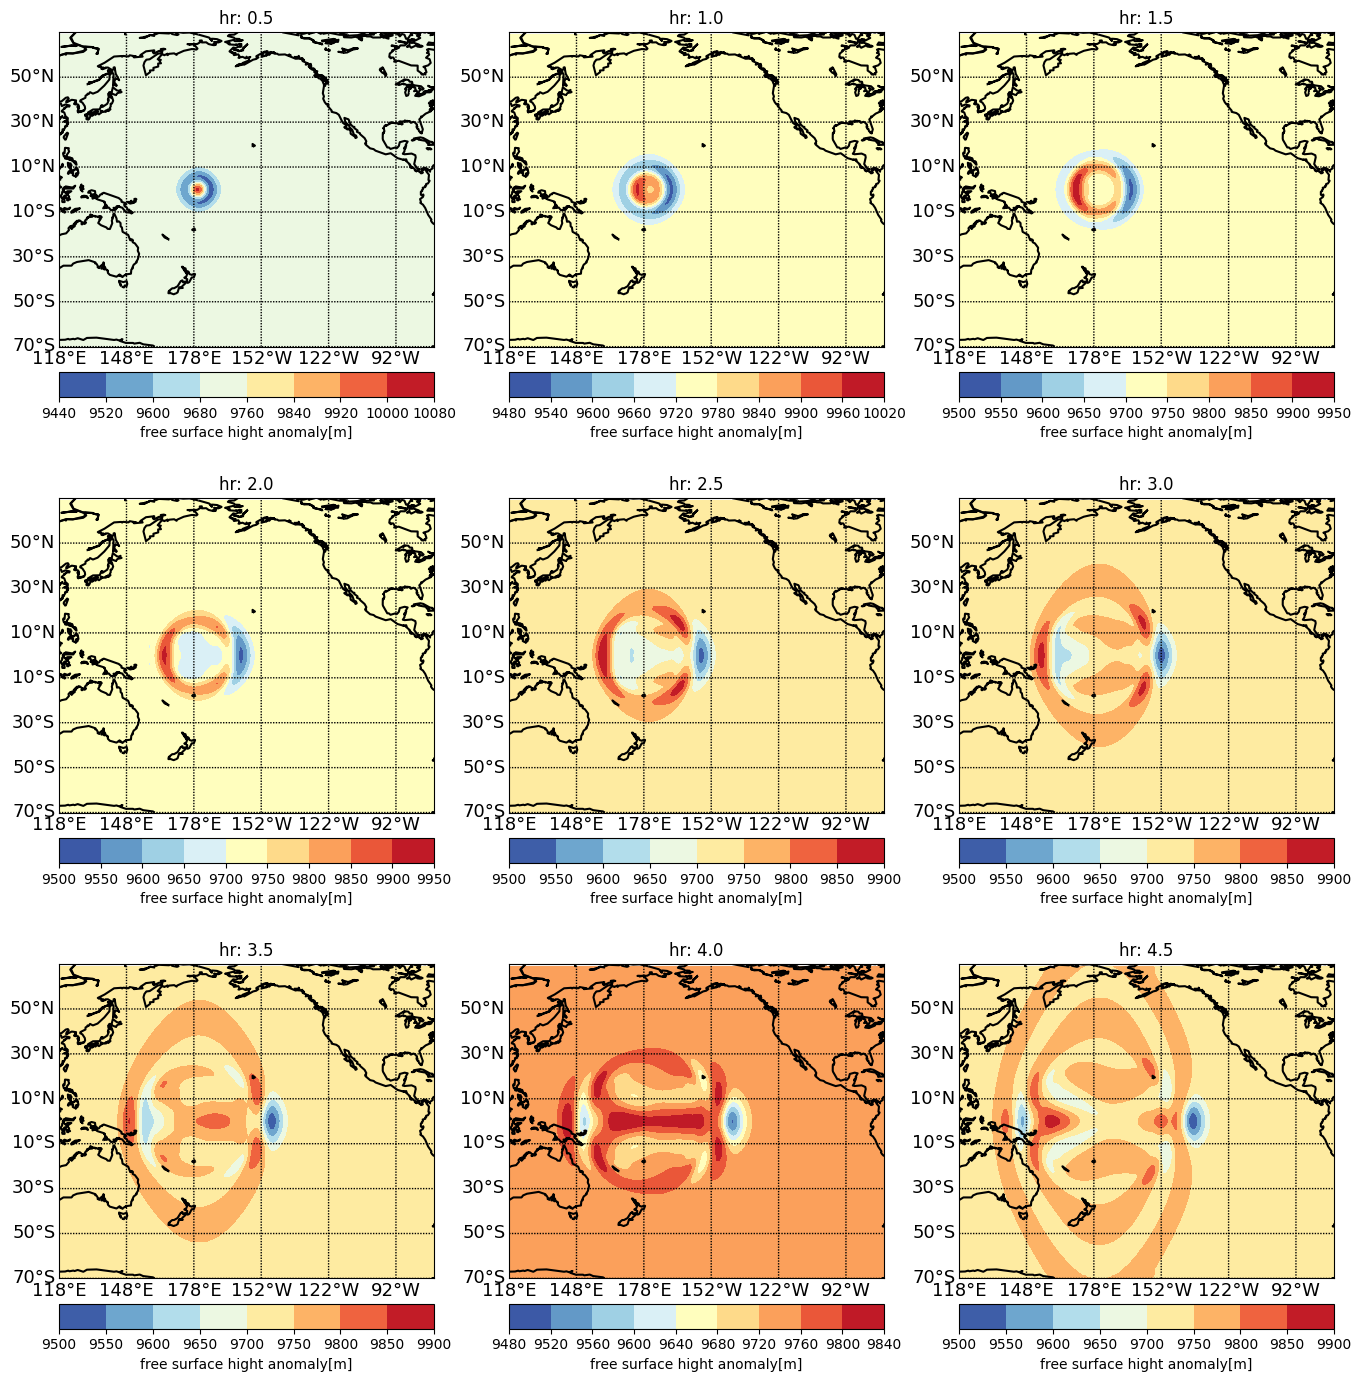

In [5]:
# Plot the height anomaly
p_d = [1,2,3,4,5,6,7,8,9]

fig = plt.figure(figsize=(15,120))
gs1 = gridspec.GridSpec(3,3,wspace=0.2, hspace=0.2, top=0.12, bottom=0.01, left=0.1, right=0.95)
i = 0

for py in p_d:
    ax = plt.subplot(gs1[i])
    plt.axis('on')
    ax.set_title('hr: {0}'.format((py)*0.5))
    map = Basemap(projection='cyl',llcrnrlat=-70,urcrnrlat=70,\
            llcrnrlon=star_lon,urcrnrlon=cut_off_lon)
    map.drawcoastlines(linewidth=1.5)
    parallels = np.arange(-70,70,20)
    meridians = np.arange(star_lon,cut_off_lon,30)
    lons,lats = np.meshgrid(lon,lat[20:159])
    xx,yy = map(lons,lats)
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=13)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=13)
    cmap = plt.get_cmap('RdYlBu_r')
    vmap = map.contourf(xx,yy,h_eq[py,20:159,:],cmap = cmap)
    #plt.quiver(x,y,u_ma[py-1,:,:],v_ma[py-1,:,:])
    #vcon = map.contour(x,y,trehft[py-1,lat_a:lat_b,:]/float(tem_gc_mean[i]),[0.05,1.5,3])
    i = i + 1
    vbar=map.colorbar(vmap,"bottom",size="8%",pad="8%")
    #vbar.set_array(color_levels)
    #vbar.set_ticks(color_levels)
    #vbar.set_ticklabels(color_levels)
    #vbar.autoscale()
    vbar.set_label("free surface hight anomaly[m]") 

plt.show()

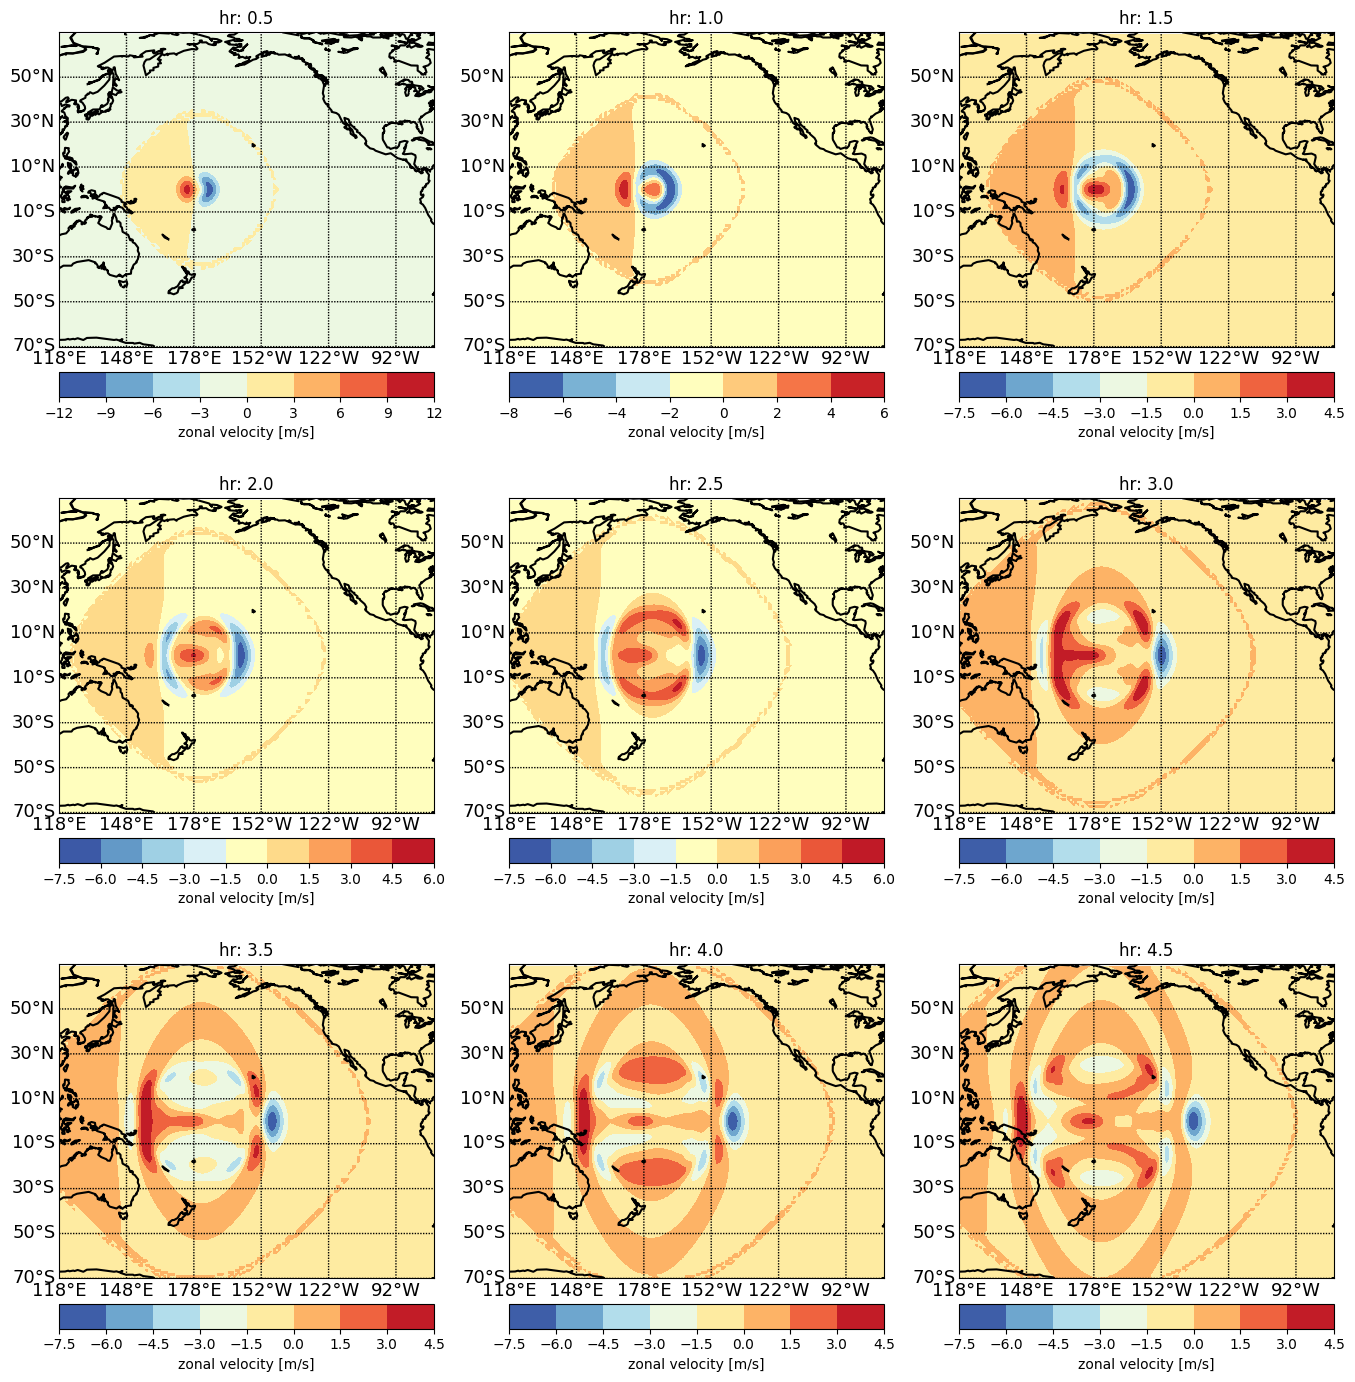

In [6]:
# Plot the zonal velocity anomaly
p_d = [1,2,3,4,5,6,7,8,9]

fig = plt.figure(figsize=(15,120))
gs1 = gridspec.GridSpec(3,3,wspace=0.2, hspace=0.2, top=0.12, bottom=0.01, left=0.1, right=0.95)
i = 0

for py in p_d:
    ax = plt.subplot(gs1[i])
    plt.axis('on')
    ax.set_title('hr: {0}'.format((py)*0.5))
    map = Basemap(projection='cyl',llcrnrlat=-70,urcrnrlat=70,\
            llcrnrlon=star_lon,urcrnrlon=cut_off_lon)
    map.drawcoastlines(linewidth=1.5)
    parallels = np.arange(-70,70,20)
    meridians = np.arange(star_lon,cut_off_lon,30)
    lons,lats = np.meshgrid(lon,lat[20:159])
    xx,yy = map(lons,lats)
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=13)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=13)
    cmap = plt.get_cmap('RdYlBu_r')
    vmap = map.contourf(xx,yy,u_eq[py,20:159,:],cmap = cmap)
    #plt.quiver(x,y,u_ma[py-1,:,:],v_ma[py-1,:,:])
    #vcon = map.contour(x,y,trehft[py-1,lat_a:lat_b,:]/float(tem_gc_mean[i]),[0.05,1.5,3])
    i = i + 1
    vbar=map.colorbar(vmap,"bottom",size="8%",pad="8%")
    #vbar.set_array(color_levels)
    #vbar.set_ticks(color_levels)
    #vbar.set_ticklabels(color_levels)
    #vbar.autoscale()
    vbar.set_label("zonal velocity [m/s]") 

plt.show()

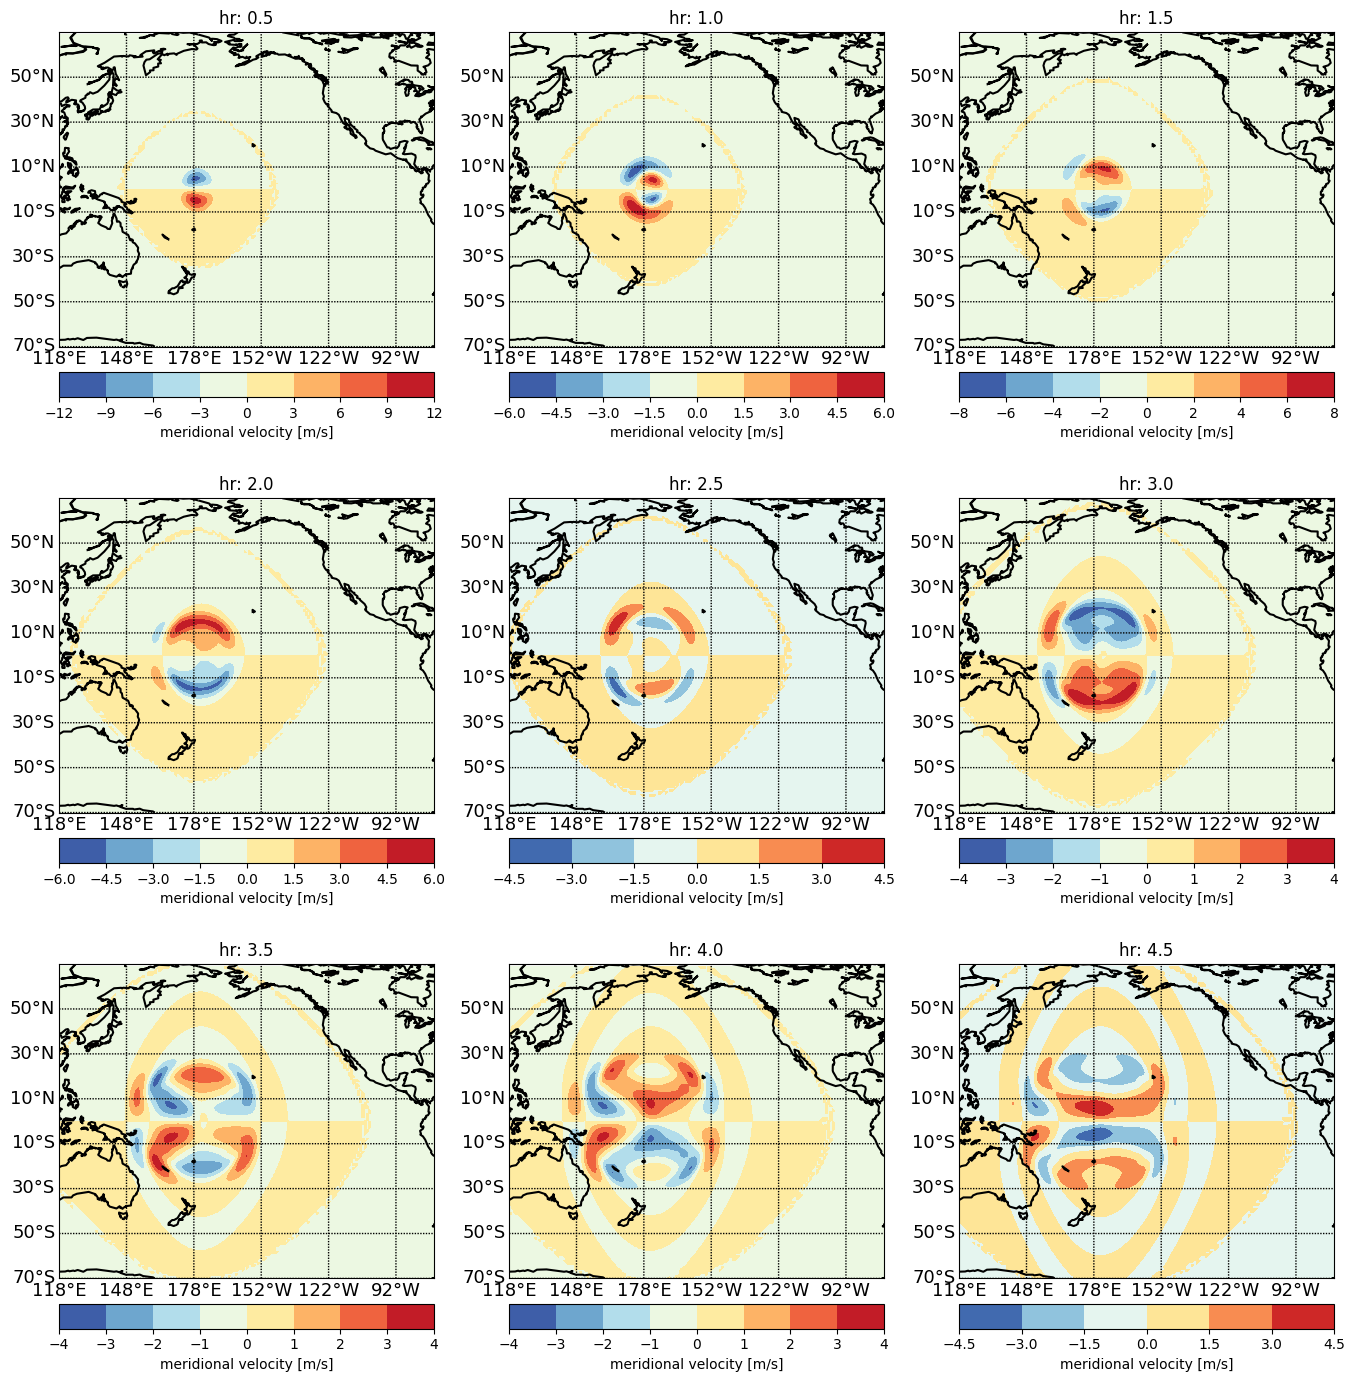

In [7]:
# Plot the meridional velocity anomaly
p_d = [1,2,3,4,5,6,7,8,9]

fig = plt.figure(figsize=(15,120))
gs1 = gridspec.GridSpec(3,3,wspace=0.2, hspace=0.2, top=0.12, bottom=0.01, left=0.1, right=0.95)
i = 0

for py in p_d:
    ax = plt.subplot(gs1[i])
    plt.axis('on')
    ax.set_title('hr: {0}'.format((py)*0.5))
    map = Basemap(projection='cyl',llcrnrlat=-70,urcrnrlat=70,\
            llcrnrlon=star_lon,urcrnrlon=cut_off_lon)
    map.drawcoastlines(linewidth=1.5)
    parallels = np.arange(-70,70,20)
    meridians = np.arange(star_lon,cut_off_lon,30)
    lons,lats = np.meshgrid(lon,lat[20:159])
    xx,yy = map(lons,lats)
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=13)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=13)
    cmap = plt.get_cmap('RdYlBu_r')
    vmap = map.contourf(xx,yy,v_eq[py,20:159,:],cmap = cmap)
    #plt.quiver(x,y,u_ma[py-1,:,:],v_ma[py-1,:,:])
    #vcon = map.contour(x,y,trehft[py-1,lat_a:lat_b,:]/float(tem_gc_mean[i]),[0.05,1.5,3])
    i = i + 1
    vbar=map.colorbar(vmap,"bottom",size="8%",pad="8%")
    #vbar.set_array(color_levels)
    #vbar.set_ticks(color_levels)
    #vbar.set_ticklabels(color_levels)
    #vbar.autoscale()
    vbar.set_label("meridional velocity [m/s]") 

plt.show()

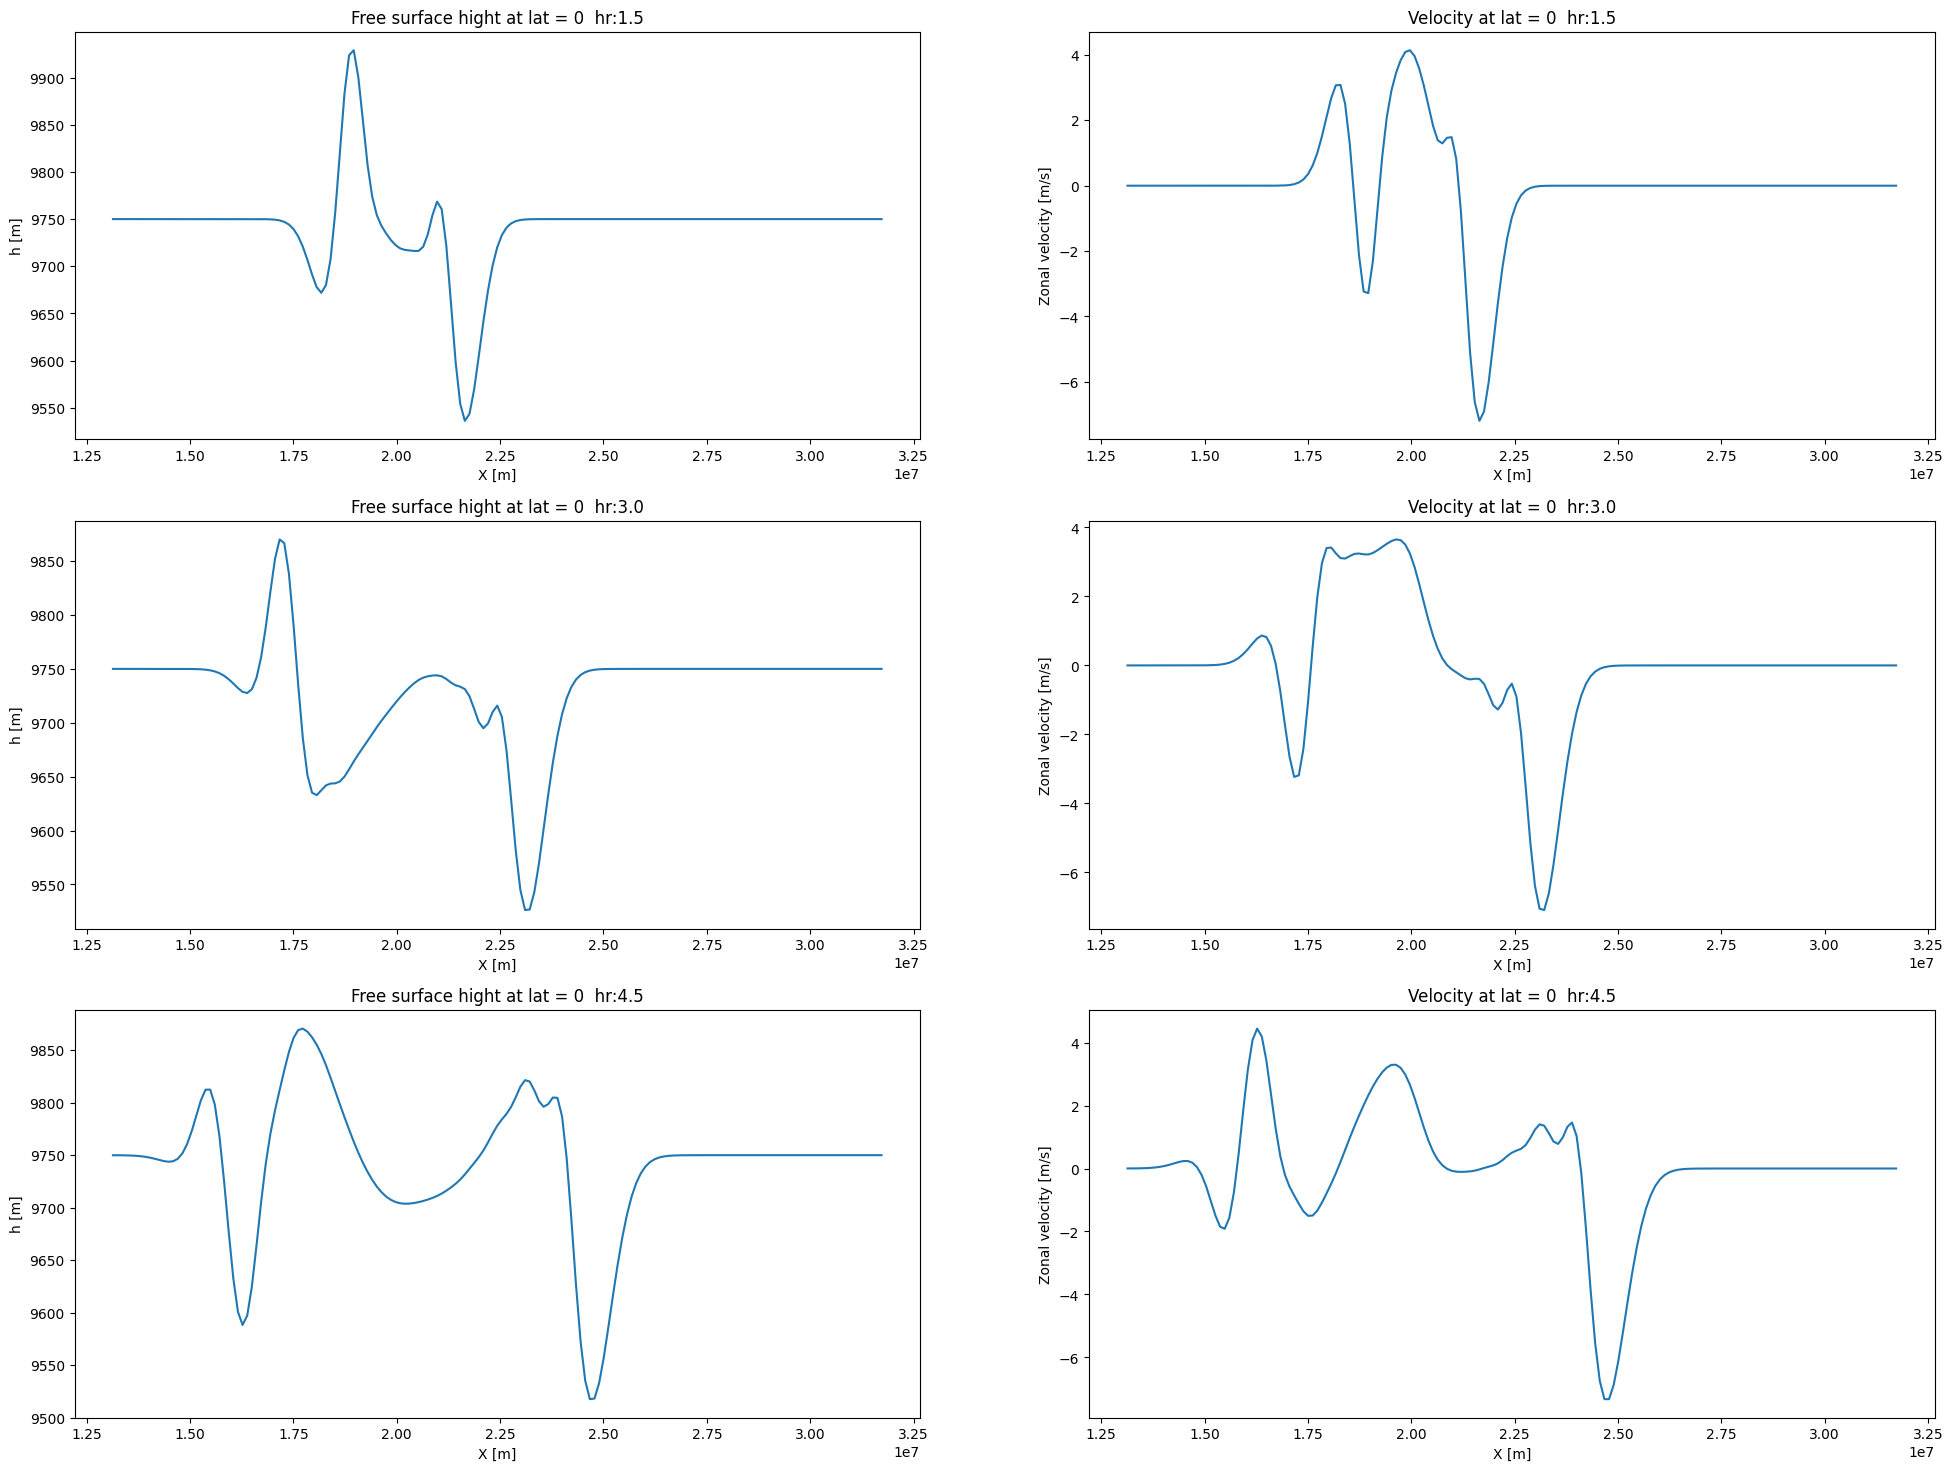

In [8]:
# Plot the ensemble omega map 
fig = plt.figure(figsize=(24,18))
gs1 = gridspec.GridSpec(3,2,wspace=0.1, hspace=0.05, top=0.12, bottom=0.008, left=0.17, right=0.845)

for py in p_d[0:3]:
    ax1 = plt.subplot(3,2,py*2-1)
    ax1.set_title('Free surface hight at lat = 0  hr:{0}'.format(py*1.5))
    plt.plot(x,h_eq[py*3,89,:])
    plt.xlabel('X [m]')
    plt.ylabel('h [m]')
    
    ax2 = plt.subplot(3,2,py*2)
    ax2.set_title('Velocity at lat = 0  hr:{0}'.format(py*1.5))
    plt.plot(x,u_eq[py*3,89,:])
    plt.xlabel('X [m]')
    plt.ylabel('Zonal velocity [m/s]')
    